# Introduction

In the following notebook, I will be attempting to predict the insurance cost per individual in the insurance dataset from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance). 

My aim in this notebook is to continue my understanding and practice of different data science techniques for data analysis. In this notebook, I will be performing the following:
- Exploratory Data Analysis using Seaborn and Matplotlib
- Utilizing Decision Tree Regressor, Random Forest Regressor and Gradient Boosted Regressor.
- Model performances will be optimized using Randomized Search
- Model performances will be evaluated using K-Fold Cross Validation

# Things to add
- Adjusted r2, AIC, BIC, updated metrics
- Model evalutation techniques for regression
- Add a Pipe
- feature engineering
- Discussion

In [1]:
#Read in libraries
import pandas as pd
import numpy as np
import pandas_profiling

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import statsmodels.api as sm
import re
import statsmodels.formula.api as smf

#Import warnings filter
from warnings import simplefilter

#Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#Set Plot Style for Notebook
sns.set(style="whitegrid")


In [2]:
#Read in data
df = pd.read_csv('insurance.csv')

# Data Overview

**Variables**

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: does beneficiary smoke cigarettes?

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

**Pandas Profiling Report**

In [3]:
# #Create Pandas Profiling Report
# profile = df.profile_report(title='Pandas Profiling Report')

# #Print Profile Report
# print(profile)

# #Create html file of Profile Report for reference
# profile.to_file(output_file="Health Insurance Pandas Report.html")

**Data Cleaning**

Encode sex and smoker variable with 1's and 0's. One-hot-encode region variable and rename new columns for clarity.

In [4]:
#Drop duplicate rows
df.drop_duplicates(inplace=True)

#Encode male:1, female:0
df['sex']= df['sex'].apply(lambda x: 1 if x =='male' else 0)

#Encode smoker:1, nonsmoker:0
df['smoker']=df['smoker'].apply(lambda x: 1 if x=='yes' else 0)

#Encode Regions w/ Dummy Variables
df = pd.get_dummies(df, columns=['region', 'children'], drop_first=False)

#Assign new column names
new_cols = ['northeast','northwest', 'southeast', 'southwest',
           'No_children', '1_child', '2_children','3_children','4_children', '5_children']

#Rename columns
df.rename(columns=dict(zip(df.columns[5:], new_cols)),inplace=True)

# Exploratory Data Analysis

### Correlation Matrix

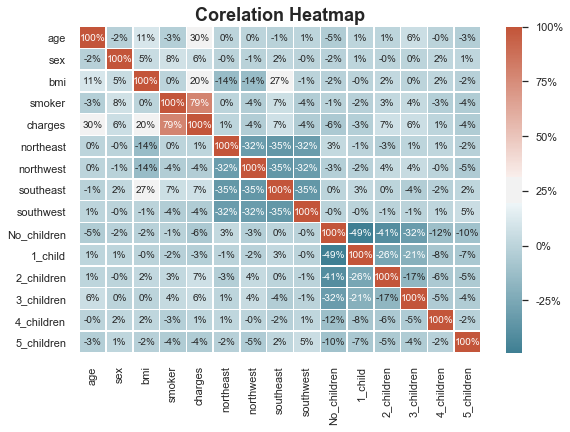

In [5]:
# Create Correlation matrix of data
corr = df.corr()

#Set plot for heatmap
f, ax = plt.subplots(figsize=(9, 6))

#Format color bar
from matplotlib.ticker import FuncFormatter
fmt = lambda x,pos: '{:.0%}'.format(x)

#Set heatmap title
ax.set_title('Corelation Heatmap',fontsize = 18, fontweight = 'bold')

#plot heatmap
sns.heatmap(corr, 
            annot = True,
            linewidths=.5, fmt='.0%',
            cbar_kws={'format': FuncFormatter(fmt)},
            cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),
            ax=ax);

Our charges variable is highly correlated with our smoker variable, followed by age and BMI respectively. I would have guessed that BMI would have had a greater impact.

Let's look into the distribution of charges of smokers vs non-smokers.

### Smoker vs Non-Smoker Charge Distributions

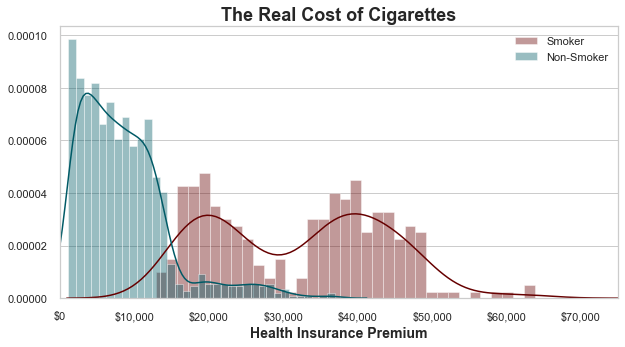

In [6]:
#Create figure
fig, ax = plt.subplots(figsize = (10,5))

#Smoker charge Distribution(Blue)
sns.distplot(df['charges'][df['smoker']==1],bins=35, label='Smoker',
             ax=ax, color = '#660000'); 

#Nonsmoker charge Distribution(Red)
sns.distplot(df['charges'][df['smoker']==0],bins=35,label='Non-Smoker',
             ax=ax, color = '#005A66');

#Set title
ax.set_title('The Real Cost of Cigarettes',fontsize = 18, fontweight = 'bold')

#Set X label
ax.set_xlabel("Health Insurance Premium", fontsize = 14, fontweight = 'bold')

#Set limits x-axis
ax.set_xlim(0,75_000)

#Format charges on x-axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

#Mute vertical grid lines
ax.xaxis.grid()

#Show legend
ax.legend();

Smokers are paying significantly more in insurance premiums than non-smokers. In our smoker distribution, there appears to be 2 populations centered around \\$20,000 and $40,000. Perhaps this has to do with age or BMI?

Let's investigate.

### BMI and Insurance Premium

Let's take a look at a scatterplot with BMI and charges. We know that smokers have a significantly higher insurance premium than non-smokers, but there appears to be two subgroups within the smoker premium distribution. Perhaps BMI has something to do with it.

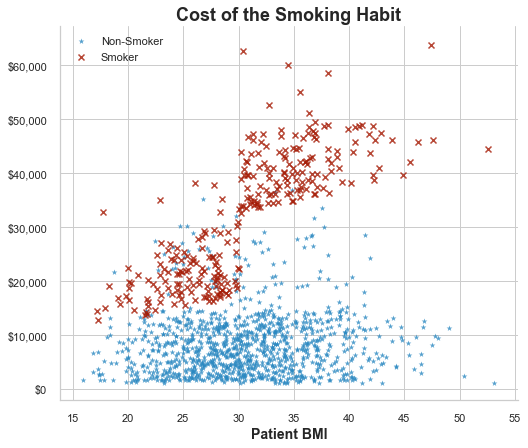

In [7]:
#Set Colors
colors= ['#2A88C1','#A51A04']

#lmplot bmi vs charges w/ smoker hue
sns.lmplot(x = 'bmi', y = 'charges', height=6, aspect=1.25, markers = ['*','x'],
           fit_reg=False, palette=colors, hue = 'smoker', legend=False, 
           data = df);


#Set Title
ax = plt.gca()
ax.set_title('Cost of the Smoking Habit',fontsize = 18, fontweight = 'bold')

#Set x and y labels
ax.set_xlabel("Patient BMI", fontsize = 14, fontweight = 'bold')
ax.set_ylabel('')

#Set new title for legend
legend = ax.legend()
legend.texts[0].set_text("Non-Smoker")
legend.texts[1].set_text("Smoker")

#Set tick label format
ax.yaxis.set_major_formatter(tick) 

Excellent, it appears that the two groups within the smoker premium distribution can be explained by the patient BMI. As patient BMI increases beyond 30, there is a significant jump in the average premium charge. 

Body mass index (BMI) is a measurement of body fat based on height and weight of a person. Weight classes are assigned to adult men and women as illustrated by the following chart:

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://amp.businessinsider.com/images/57d291cadd0895c6308b46b0-960-742.png", height=600, width =600)

How do smokers and non-smoker's charges compare within each BMI Class?

In [9]:
#Function assigns bmi class based on bmi
def bmi_classification(x):
    if x <18.5:
        return('Underweight')
    elif x <25:
        return('Healthy')
    elif x <30:
        return('Overweight')
    else:
        return('Obese')

#Apply function to df and assign to new column
df['bmi_class']= df['bmi'].apply(bmi_classification)

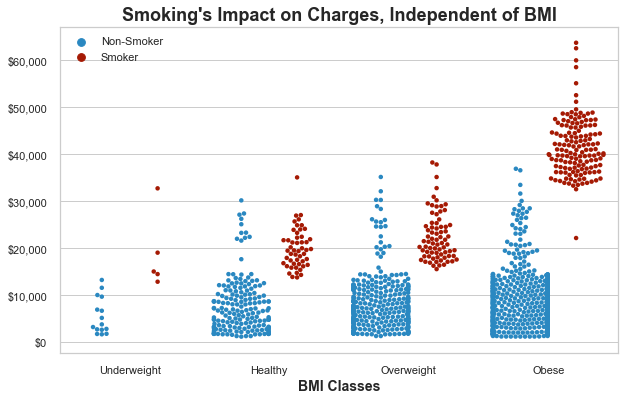

In [10]:
#Set fig-size
fig, ax = plt.subplots(figsize = (10,6))

#Set Colors
colors= ['#2A88C1','#A51A04']

#Set swarmplot bmiclass vs charges w/ smoker hue
g = sns.swarmplot(x='bmi_class', y='charges', data=df, dodge=True,
                   palette= colors, size=4.5,
              order= ["Underweight", "Healthy", "Overweight", "Obese"],
              hue='smoker');

#Set Plot Title
ax.set_title('Smoking\'s Impact on Charges, Independent of BMI',fontsize = 18, fontweight = 'bold')

#Set x and y label
ax.set_xlabel("BMI Classes", fontsize = 14, fontweight = 'bold')
ax.set_ylabel("")

#Set new title for legend
legend = ax.legend()
legend.texts[0].set_text("Non-Smoker")
legend.texts[1].set_text("Smoker")

#Format Charges Axis
ax.yaxis.set_major_formatter(tick)

Amazing, we can see the severe impact smoking has on premium charges. Let's take a look and explore our age variable and see how charges are impacted by age.

# Age and Premiums

Let's start with looking at a joint plot to explore the distribution of charges for smokers and non-smokers by age of the patient.

Text(21.625, 0.5, '')

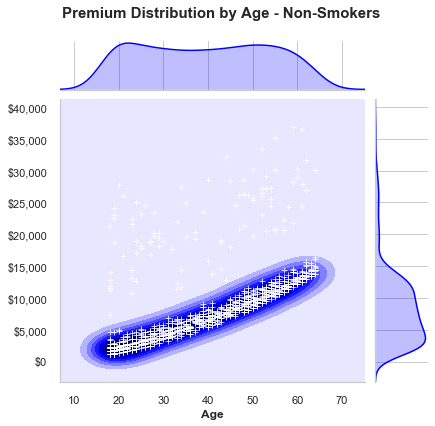

In [11]:
#Age and Charges joint plot for Non-smokers
k= sns.jointplot('age','charges',kind='kde', color='#0000FF', data=df[df['smoker']==0]);
k.plot_joint(plt.scatter, c="white", s=30, linewidth=.75, marker="+");

#Set plot title
ax = plt.gca()
plt.subplots_adjust(top=0.9)
k.fig.suptitle('Premium Distribution by Age - Non-Smokers ', fontsize = 15, fontweight = 'bold')

#Format yaxis ticks
ax.yaxis.set_major_formatter(tick) 

#Set x and y labels
ax.set_xlabel("Age", fontsize = 12, fontweight = 'bold')
ax.set_ylabel("")

Text(21.625, 0.5, '')

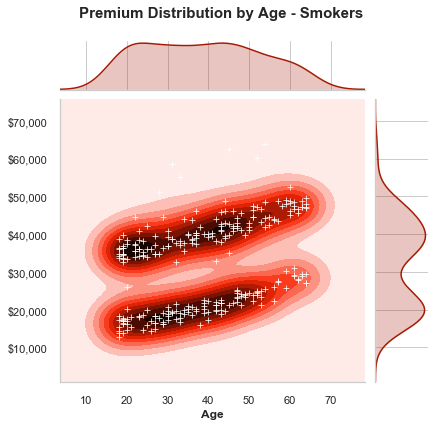

In [12]:
#Age and Charges joint plot for smokers
g= sns.jointplot('age','charges',kind='kde', color='#A51A04', data=df[df['smoker']==1]);
g.plot_joint(plt.scatter, c="white", s=30, linewidth=.75, marker="+");

#Set plot title
ax = plt.gca()
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Premium Distribution by Age - Smokers ', fontsize = 15, fontweight = 'bold')

#Format y tick label
ax.yaxis.set_major_formatter(tick)

ax.set_xlabel("Age", fontsize = 12, fontweight = 'bold')
ax.set_ylabel("")

Looking at the age distributions, we do see a slight linear relationship with charges and age(as age increases, so does the premium). We do see a pretty clear impact of smoking on the total premium, and interestingly enough it looks like those 2 populations we see in the smoker's distribution is due to BMI.

Let's visualize BMI and Age in a 3d space to see if we can find some relationship of interest.

# BMI, Age, and Charges

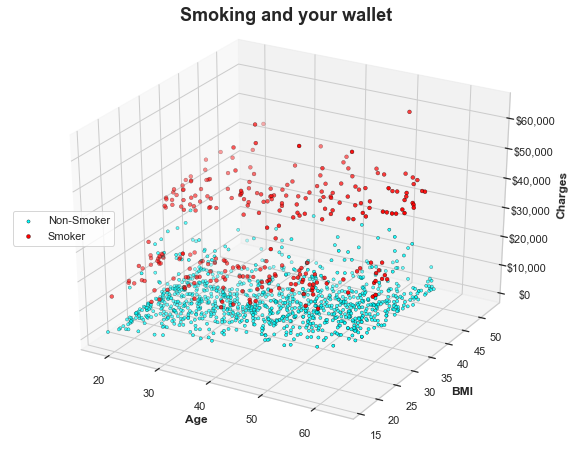

In [13]:
#Import 3D 
from mpl_toolkits.mplot3d import Axes3D

#Create figure
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D scatter plot for Non-Smokers
ax.scatter(df['age'][df['smoker']==0], df['bmi'][df['smoker']==0], 
           df['charges'][df['smoker']==0], c='cyan',edgecolors = 'black',linewidth = .35, s=10, label = 'Non-Smoker')

# Plot 3D scatter plot for Smokers
ax.scatter(df['age'][df['smoker']==1], df['bmi'][df['smoker']==1], df['charges'][df['smoker']==1], 
           c='red', s=15,edgecolors = 'black', linewidth = .35, label = 'Smoker')



#Set Title
ax.set_title('Smoking and your wallet', pad = 25,fontsize = 18, fontweight = 'bold')

#Set Axis Labels
ax.set_xlabel("Age", fontsize = 12, labelpad = 7, fontweight = 'bold')
ax.set_ylabel("BMI", fontsize = 12, labelpad = 10, fontweight = 'bold')
ax.set_zlabel("Charges", fontsize = 12, labelpad = 15, fontweight = 'bold')

#Format z tick label and add spacing
ax.zaxis.set_major_formatter(tick)
ax.tick_params(axis='z', which='major', pad=8)

#Set new title for legend
ax.legend(loc = 6, frameon=True)


plt.show()

The smoking variable by far is the most correlated with charges, as illustrated by the clear seperation for higher cost across both age and BMI. Interestingly enough, we do see more of the extreme cases as BMI increases, but not so much with age. 

Let's do a little exploration looking into how BMI varies across the United States before we move onto machine learning.

# BMI by Regions across the United States

In [14]:
#Convert region dummies back to cat and assign to df
dummies = df.loc[: ,'northeast': 'southwest']
df['region'] = dummies.idxmax(axis=1).str.capitalize()

Text(0, 0.5, 'BMI')

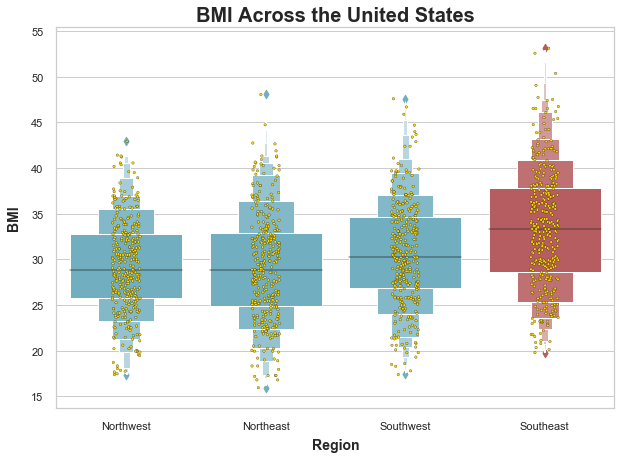

In [15]:
#Set Plot size
fig, ax = plt.subplots(figsize=(10,7))

#Set Colors
my_pal = {region: "r" if region == "Southeast" else "c" for region in df.region.unique()}


#boxenplot bmi by region
g= sns.boxenplot(y = 'bmi', x='region', 
              order= ['Northwest', 'Northeast', 'Southwest', 'Southeast'],
                palette= my_pal,
              data = df, ax=ax);

#Swarmplot bmi by region
k = sns.stripplot(y = 'bmi', x='region', data=df, 
                   edgecolor='black',linewidth=.25,
                   order= ['Northwest', 'Northeast', 'Southwest', 'Southeast'],
                    size=2.5, jitter=True, color="gold", ax=ax)

#Set Title
ax.set_title('BMI Across the United States',fontsize = 20, fontweight = 'bold')

#Set Axis Labels
ax.set_xlabel("Region", fontsize = 14, labelpad = 7, fontweight = 'bold')
ax.set_ylabel("BMI", fontsize = 14, labelpad = 10, fontweight = 'bold')


The region most associated with having a higher BMI is the Southeast, having an almost 5 unit median than the Northwest. We do know that region was not correlated with charges, further supporting the notion that cigarettes are incredibly toxic for your health.

# Machine Learning

**Feature Engineering**

In [16]:
#Drop bmi_class and region
df.drop(columns=['bmi_class', 'region'], inplace=True)

**Feature Distributions**

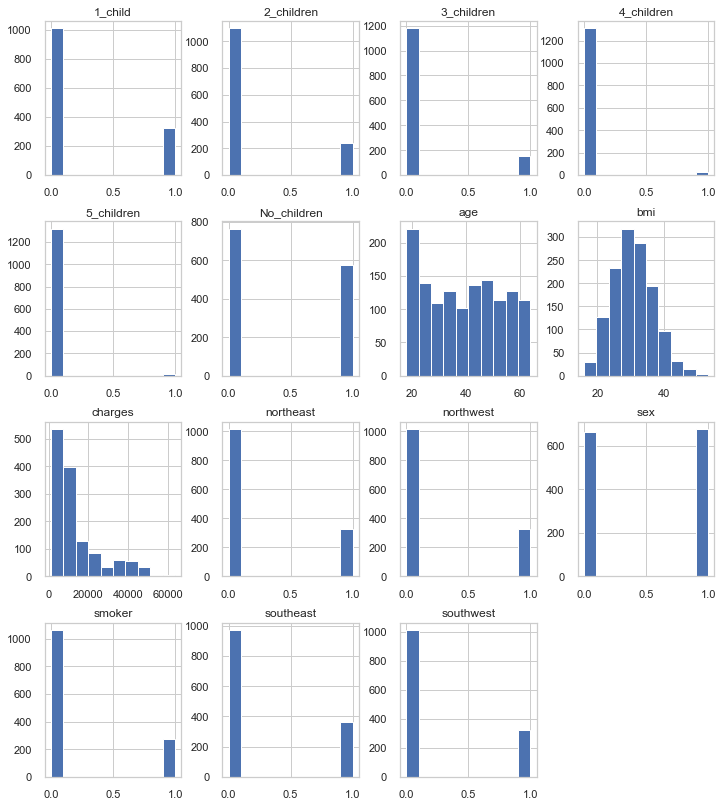

In [17]:
#View Histogram of all features
df.hist(figsize=(12,12))

#add space between subplots
plt.subplots_adjust(top=1)

Will apply the following transformations:
- Log transform to charges 

In [18]:
#Apply log transformation to charges
df.charges = np.log(df.charges)

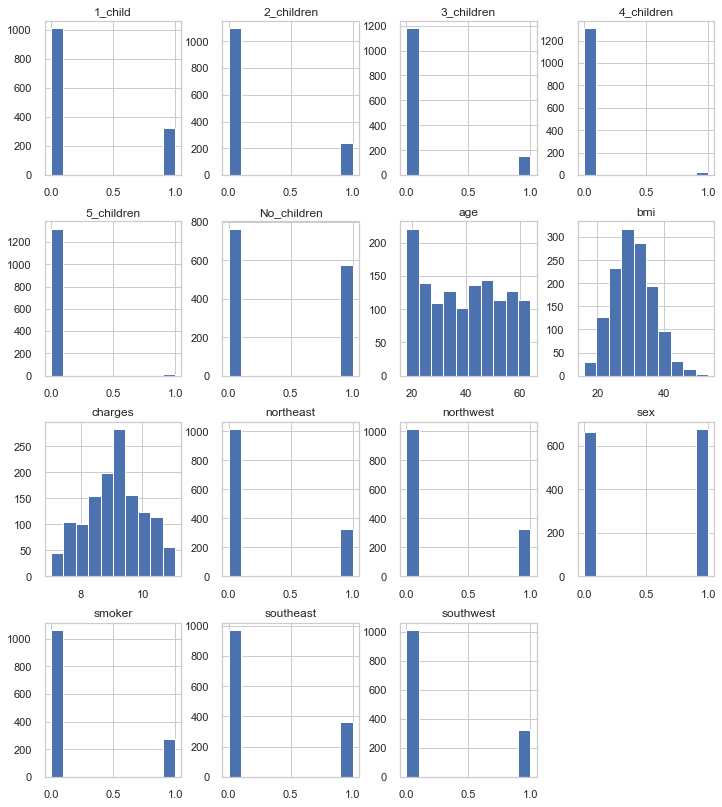

In [19]:
#View Histogram of all features
df.hist(figsize=(12,12))

#add space between subplots
plt.subplots_adjust(top=1)

**Split Data and Prepare for Machine Learning Pipeline**

In [20]:
#Assign data to X and y
X= df.drop('charges', axis=1).values
y= df['charges'].values


#Print data shapes
print('X data shape: ', X.shape)
print('y data shape: ', y.shape, '\n')

X data shape:  (1337, 14)
y data shape:  (1337,) 



In [21]:
#Import splitter
from sklearn.model_selection import train_test_split

#Split data
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state = 42)

#Print data shapes
print('X_train data shape:{} \ny_train shape:{}'.format(X_train.shape, y_train.shape))
print('X_test data shape:{} \ny_test shape:{}'.format(X_test.shape, y_test.shape))


X_train data shape:(1002, 14) 
y_train shape:(1002,)
X_test data shape:(335, 14) 
y_test shape:(335,)


**Pipeline for Base Model evaluations**

For our model, we will want to select the models with the 2 highest $R^2$ value and lowest RMSE. We will optimize each of them and use the best model to test on our test data.

In [22]:
#Import Pipeline
from sklearn.pipeline import Pipeline

#Import scaler
from sklearn.preprocessing import StandardScaler

#Import cross_validate
from sklearn.model_selection import cross_val_predict

#Import metrics
from sklearn import metrics

#Import Regression models
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


#Instantiate Pipeline
pipe = Pipeline([('scaler', StandardScaler()),
                ('classifier', 'passthrough')])

#Instantiate model and append to clf
clf=[]
clf.append(LinearRegression())
clf.append(SGDRegressor())
clf.append(LinearSVR())
clf.append(DecisionTreeRegressor())
clf.append(RandomForestRegressor())
clf.append(GradientBoostingRegressor())

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

#Block warnings for readability
from warnings import filterwarnings
filterwarnings('ignore')

#Fit base models to training data
for clf in clf:
    #update pipe with next model
    pipe.set_params(classifier = clf)
    #run 10 fold CV
    preds = cross_val_predict(pipe, X_train, y_train, cv=10)
        
    #Print scores
    print('--------------------------------------------')
    print(str(clf))
    print('--------------------------------------------')
    regression_results(y_train, preds)

--------------------------------------------
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
--------------------------------------------
explained_variance:  0.741
mean_squared_log_error:  0.0021
r2:  0.741
MAE:  0.2965
MSE:  0.2136
RMSE:  0.4622
--------------------------------------------
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
--------------------------------------------
explained_variance:  0.7411
mean_squared_log_error:  0.0021
r2:  0.7411
MAE:  0.2959
MSE:  0.2135
RMSE:  0.4621
--------------------------------------------
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          inte

Our ensemble models perform best. We will optimize the performance of both the RandomForestRegressor and the GradientBoostingRegressor using RandomSearchCV. We will then select the best model to use on the test data based on $R^2$.

**Random Forest Optimization**

In [23]:
#Instantiate RandomForestRegressor
rforest = RandomForestRegressor(random_state=0, n_jobs=-1)

#Get parameters to optimize
print(rforest.get_params)

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)>


In [24]:
# #Select values for max_features
# max_features= ['auto', 'sqrt', 'log2', None]

# #Select values for max_leaf_nodes
# max_leaf_nodes= [None]

# #Select values for min_samples_leaf
# min_samples_leaf= [4,5,6,7] 

# #Select values for min_samples_split
# min_samples_split= [4,5,6,7]

# #Select values for n_estimators
# n_estimators= [500, 625, 750, 875, 1000]

# #Create random_grid
# random_grid = {'max_features':max_features,
#                 'max_leaf_nodes':max_leaf_nodes,
#                 'min_samples_leaf':min_samples_leaf,
#                 'min_samples_split':min_samples_split,
#                 'n_estimators':n_estimators
#                     }

# #Best paramters are:  {'n_estimators': 875, 'min_samples_split': 4, 'min_samples_leaf': 7, 
# #'max_leaf_nodes': None, 'max_features': 'auto'}

In [25]:
# #Import RandomizedSearchCV
# from sklearn.model_selection import RandomizedSearchCV

# #import make_scorer for additional metrics
# from sklearn.metrics import make_scorer
# scoring = {'r2':'r2',
#           'MSE': make_scorer(metrics.mean_squared_error)}

# #Instantiate RandomizedSearchCV
# rand_rf= RandomizedSearchCV(rforest, param_distributions = random_grid,
#                             n_iter=10, cv=10,random_state=0,
#                               verbose=2, scoring =scoring, refit='r2')

In [27]:
# #takes 10 min
# #Fit to data
# cv_results = rand_rf.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2, total=   3.3s
[CV] n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV]  n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2, total=   3.2s
[CV] n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2 
[CV]  n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2, total=   3.4s
[CV] n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2 
[CV]  n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2, total=   3.2s
[CV] n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2 
[CV]  n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2, total=   3.6s
[CV] n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2 
[CV]  n_estimators=625, min_samples_split=4, min_samples_leaf=5, max_leaf_nodes=None, max_features=log2, tot

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.7min finished


In [90]:
#Best Params
print("Best paramters are: ",cv_results.best_params_)

#Get r2 score
print('Best r2 score: {:.5f}'.format(cv_results.best_score_))

# #Get MSE scores
#print(cv_results.cv_results_)

# #Get RMSE
# print(cv_results['mean_test_MSE'])

#Display all columns of df
pd.set_option('display.max_columns', 35)

#Convert cv_results_ into a datafrae
results = pd.DataFrame(cv_results.cv_results_)
test = results.mean_test_MSE[results.rank_test_MSE == 1].values

print('Best RMSE score: {:.5f}'.format(np.sqrt(test[0])))
#Print best RMSE score
#print('Best RMSE Score: {:.3f}', results.mean_test_MSE[results.rank_test_MSE == 1])

Best paramters are:  {'n_estimators': 875, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_leaf_nodes': None, 'max_features': 'auto'}
Best r2 score: 0.80507
Best RMSE score: 0.46207


GradientBoostingRegressor

In [ ]:
# #Instantiate model and view parameters
# gbr = GradientBoostingRegressoradientBoostingRegressor()
# print('GBR Paramaters:', gbr.get_params)

In [ ]:
#

In [ ]:
# rand_gbr = RandomizedSearchCV(gbr, param_distributions=random_grid,n_iter=100, cv=10,refit='neg_mean_squared_error',
#                              n_jobs=-1, scoring=('r2', 'neg_mean_squared_error'))

In [ ]:
# #Summon Gradient Boosting Regressor
# from sklearn.ensemble import GradientBoostingRegressor

# #Instantiate model
# gbr = GradientBoostingRegressor(random_state=0)

# #Parameters used by random forest
# print('Parameters currently in use for Gradient Boosted Regressor:')
# print(gbr.get_params)

**View Decision Tree Feature Importance**

In [ ]:
# #Fit tuned tree to data
# gbr.fit(X,y)

# #Plot feature importance
# plot_feature_importances(gbr)

**Find Optimum Hyperparameters using Random Search**

In [ ]:
# #Parameters used by random forest
# print('Parameters currently in use for Gradient Boosted Regressor:')
# print(gbr.get_params)

**Tune GBR**

In [ ]:
# #Summon model with tuned paramters
# tuned_gbr = GradientBoostingRegressor(random_state=0, n_estimators= 2733,
#                                  min_samples_split = 12, min_samples_leaf = 2,
#                                  max_features = 'auto',max_depth = 2,
#                                  loss = 'huber', learning_rate = 0.01)

# #Instantiate model
# scores = cross_val_score(tuned_gbr, X, y, cv= 5)

# #Print Cross Validation Score
# print("Cross Validation Scores: {}".format(scores))
# print('Average Cross Validation Score: {:.3f}'.format(np.mean(scores)))

**View Decision Tree Feature Importance**

In [ ]:
# #Fit tuned model to data
# tuned_gbr.fit(X,y)

# #View Feature importances
# plot_feature_importances(gbr)

**Conclusions**

The random forest regressor performed best with an accuracy of 86%. All of our feature importance plots revealed that the most valuable feature was the smoking variable (as we already saw from the EDA)

Some pieces of information that could have been of great benefit to this data set would have been the cause of hospitalization. There were some outliers for young people with really high premiums which may not be caused by smoking but some other confounding variable, such as alcohol or drug use. 
Another interesting piece if information that would have been helpful would be the length of hospitalization. Generally speaking, hospital stay would probably linearly correlate with charges since hospitals are charging for medicines used daily as well as the room used by the patient. 